# **Predictive Incident Management (Using XGBClassifier)**
*created by: Eingeline Nichole Roque - BIA Intern*

import main python libraries and dataset to be used

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
incident_df = pd.read_excel('/content/drive/MyDrive/incident_v3.xlsx')

In [4]:
df = incident_df.copy()

In [16]:
df.head(5)

,sys_id,number,opened_at,closed_at,category,subcategory,priority,severity,assignment_group,assigned_to,state,close_code,close_notes,cmdb_ci,location
0,SYS00001,INC00001,2023-06-08,2023-07-08,Network,Connectivity,Low,Major,Security Ops,User_19,CLOSED,No Issue Found,User Error,Server_16,Site_14
1,SYS00002,INC00002,2023-06-19,2023-07-02,Network,Bandwidth,Critical,Major,IT Support,User_2,CLOSED,Resolved,Temporary Solution,Server_68,Site_4
2,SYS00003,INC00003,2023-11-13,2023-12-08,Software,Application Crash,Critical,Major,IT Support,User_8,CLOSED,Workaround,Fixed,Server_93,Site_7
3,SYS00004,INC00004,2023-06-12,2023-06-16,Security,Phishing,Medium,Minor,Security Ops,User_24,CLOSED,No Issue Found,Fixed,Server_40,Site_16
4,SYS00005,INC00005,2023-07-20,2023-07-21,Software,Application Crash,High,Critical,Security Ops,User_8,CLOSED,Workaround,User Error,Server_42,Site_1


## **Data Cleaning and Resampling**
- needed operation as there is an imbalance in the raw dataset.

In [5]:
df['state'].value_counts()

,count
state,
CLOSED,8012
OPEN,1988


### *oversampling the minority class ('open' incidents) to have an equal ratio with the majority class ('closed' incidents)*

In [7]:

from imblearn.over_sampling import RandomOverSampler


X = df.drop('state', axis=1)
y = df['state']


df_open = df[df['state'] == 'OPEN']
df_closed = df[df['state'] == 'CLOSED']

df_combined = pd.concat([df_open, df_closed])

X_combined = df_combined.drop('state', axis=1)
y_combined = df_combined['state']

# target state to oversample = open states (0)
target_state_open = 'OPEN'

target_size_closed = df_closed.shape[0]

# RandomOverSampler - a class to over-sample the minority class(es) by picking samples at random with replacement
ros = RandomOverSampler(sampling_strategy={target_state_open: target_size_closed}, random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_combined, y_combined)

# new dataframe
df_balanced = pd.DataFrame(X_resampled, columns=X_combined.columns)
df_balanced['state'] = y_resampled

print(df_balanced['state'].value_counts())


state
OPEN      8012
CLOSED    8012
Name: count, dtype: int64


In [8]:
df_balanced

,sys_id,number,opened_at,closed_at,category,subcategory,priority,severity,assignment_group,assigned_to,close_code,close_notes,cmdb_ci,location,state
0,SYS00011,INC00011,2023-05-24,NaT,Network,VPN Issue,Medium,Major,IT Support,User_24,NaN,NaN,Server_93,Site_17,OPEN
1,SYS00014,INC00014,2023-02-10,NaT,Network,Connectivity,Medium,Minor,Security Ops,User_5,NaN,NaN,Server_97,Site_14,OPEN
2,SYS00025,INC00025,2023-05-16,NaT,Software,Application Crash,Medium,Major,Network Team,User_27,NaN,NaN,Server_66,Site_5,OPEN
3,SYS00030,INC00030,2023-12-22,NaT,Hardware,Laptop,Critical,Critical,Security Ops,User_8,NaN,NaN,Server_68,Site_4,OPEN
4,SYS00037,INC00037,2023-12-01,NaT,Network,Bandwidth,High,Minor,Software Dev,User_50,NaN,NaN,Server_1,Site_7,OPEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16019,SYS00383,INC00383,2023-10-21,NaT,Hardware,Printer,Medium,Minor,Security Ops,User_26,NaN,NaN,Server_93,Site_4,OPEN
16020,SYS09803,INC09803,2023-02-07,NaT,Network,VPN Issue,Low,Minor,Software Dev,User_28,NaN,NaN,Server_91,Site_11,OPEN
16021,SYS09801,INC09801,2023-05-27,NaT,Hardware,Printer,Critical,Critical,Network Team,User_8,NaN,NaN,Server_50,Site_19,OPEN
16022,SYS04495,INC04495,2023-03-24,NaT,Software,Application Crash,Medium,Major,Security Ops,User_7,NaN,NaN,Server_13,Site_15,OPEN


visualization of the majority and minority class

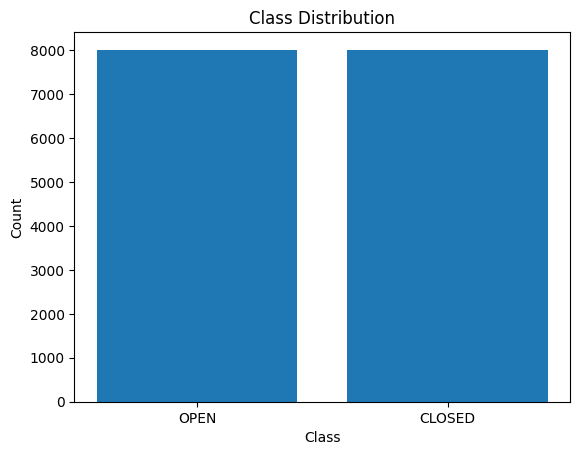

In [9]:
x = df_balanced.drop(['state'], axis=1)
y = df_balanced['state']

count_class = y.value_counts() # Count the occurrences of each class
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class.index)
plt.show()

### checking for NaN values in the dataframe for removal

In [10]:
df_balanced.columns[df_balanced.isna().any()]

Index(['closed_at', 'close_code', 'close_notes'], dtype='object')

In [11]:
len(df_balanced[df_balanced.isna().any(axis=1)])

8012

convert 'state' to binary (dependent variable)

In [12]:
df_balanced['is_closed'] = (df_balanced['closed_at'].notnull()).astype(int)

In [13]:
df_balanced['is_closed'].unique()

array([0, 1])

## Feature Engineering - Numerical Features

In [14]:
df_balanced['day_of_week'] = df_balanced['opened_at'].dt.dayofweek

In [15]:
df_balanced['is_weekend'] = df_balanced['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

In [16]:
df_balanced['day_of_month'] = df_balanced['opened_at'].dt.day
df_balanced['week_of_year'] = df_balanced['opened_at'].dt.isocalendar().week.astype(int)
df_balanced['quarter_of_year'] = df_balanced['opened_at'].dt.quarter

In [17]:
snapshot_date = df_balanced['opened_at'].max() + pd.Timedelta(days=1)

df_balanced['incident_age_at_snapshot_seconds'] = (snapshot_date - df_balanced['opened_at']).dt.total_seconds()

In [18]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16024 entries, 0 to 16023
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   sys_id                            16024 non-null  object        
 1   number                            16024 non-null  object        
 2   opened_at                         16024 non-null  datetime64[ns]
 3   closed_at                         8012 non-null   datetime64[ns]
 4   category                          16024 non-null  object        
 5   subcategory                       16024 non-null  object        
 6   priority                          16024 non-null  object        
 7   severity                          16024 non-null  object        
 8   assignment_group                  16024 non-null  object        
 9   assigned_to                       16024 non-null  object        
 10  close_code                        8012 non-nul

In [19]:
# drop columns not needed for training

columns_to_drop = ['opened_at', 'closed_at', 'state', 'close_code']
df_balanced = df_balanced.drop(columns=columns_to_drop)

In [20]:
df_balanced.tail(10)

,sys_id,number,category,subcategory,priority,severity,assignment_group,assigned_to,close_notes,cmdb_ci,location,is_closed,day_of_week,is_weekend,day_of_month,week_of_year,quarter_of_year,incident_age_at_snapshot_seconds
16014,SYS01791,INC01791,Security,Phishing,Critical,Critical,Software Dev,User_48,NaN,Server_34,Site_11,0,1,0,23,21,2,19353600.0
16015,SYS06503,INC06503,Hardware,Desktop,Medium,Minor,Network Team,User_10,NaN,Server_47,Site_10,0,3,0,5,40,4,7689600.0
16016,SYS03014,INC03014,Security,Phishing,Critical,Critical,IT Support,User_27,NaN,Server_19,Site_1,0,2,0,29,13,1,24105600.0
16017,SYS08145,INC08145,Security,Unauthorized Access,Critical,Major,Software Dev,User_43,NaN,Server_15,Site_3,0,3,0,30,13,1,24019200.0
16018,SYS01852,INC01852,Hardware,Printer,Medium,Minor,IT Support,User_48,NaN,Server_17,Site_2,0,0,0,16,3,1,30326400.0
16019,SYS00383,INC00383,Hardware,Printer,Medium,Minor,Security Ops,User_26,NaN,Server_93,Site_4,0,5,1,21,42,4,6307200.0
16020,SYS09803,INC09803,Network,VPN Issue,Low,Minor,Software Dev,User_28,NaN,Server_91,Site_11,0,1,0,7,6,1,28425600.0
16021,SYS09801,INC09801,Hardware,Printer,Critical,Critical,Network Team,User_8,NaN,Server_50,Site_19,0,5,1,27,21,2,19008000.0
16022,SYS04495,INC04495,Software,Application Crash,Medium,Major,Security Ops,User_7,NaN,Server_13,Site_15,0,4,0,24,12,1,24537600.0
16023,SYS06327,INC06327,Network,Connectivity,Medium,Critical,Security Ops,User_42,NaN,Server_38,Site_1,0,5,1,27,21,2,19008000.0


## Feature Engineering - Categorical Features

In [21]:
from sklearn.preprocessing import OrdinalEncoder

In [22]:
priority_order = ['Low', 'Medium', 'High', 'Critical']
severity_order = ['Minor', 'Major', 'Critical']

In [23]:
encoder_priority = OrdinalEncoder(categories=[priority_order], dtype=int)
df_balanced['priority_encoded'] = encoder_priority.fit_transform(df_balanced[['priority']])

In [24]:
encoder_severity = OrdinalEncoder(categories=[severity_order], dtype=int)
df_balanced['severity_encoded'] = encoder_severity.fit_transform(df_balanced[['severity']])

In [25]:
df_balanced['priority_severity_interaction'] = df_balanced['priority_encoded'] * df_balanced['severity_encoded']

In [26]:

df_balanced = df_balanced.drop(columns=['priority', 'severity'], axis=1)

## **Data Preparation**

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

In [53]:
categorical_cols = [
    'category',
    'subcategory',
    'assignment_group',
    'assigned_to',
    'cmdb_ci',
    'location',
]

numerical_features = ['priority_encoded',
                      'severity_encoded',
                      'day_of_week', 'is_weekend',
                      'day_of_month', 'week_of_year',
                      'quarter_of_year',
                     'incident_age_at_snapshot_seconds',
                     'priority_severity_interaction']

In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols),
        ('numerical_scaler', MinMaxScaler(), numerical_features)
    ],
    remainder='drop'
)

## **Data Training**

In [30]:
X = df_balanced.drop(['is_closed'], axis=1, errors='ignore')
Y = df_balanced['is_closed']

In [31]:
from sklearn.model_selection import train_test_split
from collections import Counter

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

In [33]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [39]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [40]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

In [41]:
# to check the number of samples and features of the training dataset

num_samples, num_features = X_train_processed.shape
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

Number of samples: 12819
Number of features: 199


In [42]:
# xgboost classifier
xgb_clf = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42, class_weight='balanced')

# train
xgb_clf.fit(X_train_processed, Y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:05:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [43]:
# predictions on the test data
Y_pred = xgb_clf.predict(X_test_processed)

# evaluation metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8303
Precision: 0.8844
Recall: 0.7597
F1-score: 0.8173


visualization to further understand the initial training

In [44]:
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, Y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1603
           1       0.88      0.76      0.82      1602

    accuracy                           0.83      3205
   macro avg       0.84      0.83      0.83      3205
weighted avg       0.84      0.83      0.83      3205


Confusion Matrix:
[[1444  159]
 [ 385 1217]]


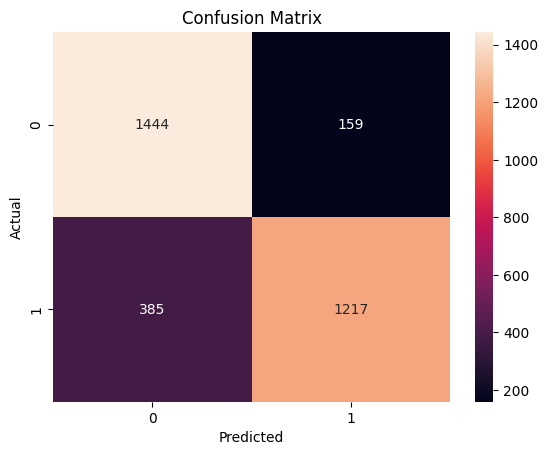

In [45]:
# heatmap of the initial model

sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Hyperparameter Tuning (using Optuna)**

In [46]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 12.5 MB/s eta 0:00:00


applied SMOTETomek to handle imbalance on data (if it is still existing) and StratifiedKFold for cross-validation

In [47]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import RepeatedStratifiedKFold

In [49]:
def objective(trial):
    """Defines the objective function for Optuna."""

    params = {
        'objective': 'binary:logistic',
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
    }

    # pipeline to correctly handle resampling within cross-validation
    model = IMBPipeline([
        ('preprocessor', preprocessor),
        ('smotetomek', SMOTETomek(random_state=42)),
        ('classifier', XGBClassifier(**params, class_weight='balanced'))
    ])

    # to handle imbalance data
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
    scores = cross_val_score(model, X, Y, cv=cv, scoring='f1', n_jobs=-1)

    # return the average F1-score across folds
    return scores.mean()

# optimize
study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=10)


print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-26 08:05:34,839] A new study created in memory with name: no-name-9caa5a7b-74bf-4b40-9013-d30b533c0508
[I 2025-05-26 08:08:13,240] Trial 0 finished with value: 0.8313196794030734 and parameters: {'n_estimators': 842, 'learning_rate': 0.05492278580331598, 'max_depth': 7, 'subsample': 0.7297861262686697, 'colsample_bytree': 0.8201737244979148, 'gamma': 0.5261515390581705, 'min_child_weight': 3, 'reg_alpha': 0.7609714340229038, 'reg_lambda': 0.4093196052802658}. Best is trial 0 with value: 0.8313196794030734.
[I 2025-05-26 08:10:06,776] Trial 1 finished with value: 0.6972811056475365 and parameters: {'n_estimators': 451, 'learning_rate': 0.033684910329133774, 'max_depth': 5, 'subsample': 0.6490072903489914, 'colsample_bytree': 0.7030696353026129, 'gamma': 0.3770180488167151, 'min_child_weight': 3, 'reg_alpha': 0.25899893784521477, 'reg_lambda': 0.37815401014701355}. Best is trial 0 with value: 0.8313196794030734.
[I 2025-05-26 08:11:59,171] Trial 2 finished with value: 0.733597

Best trial:
  Value: 0.860459612819683
  Params: 
    n_estimators: 914
    learning_rate: 0.03397655562503694
    max_depth: 10
    subsample: 0.7543553240517082
    colsample_bytree: 0.8766268643227735
    gamma: 0.3387458397928187
    min_child_weight: 3
    reg_alpha: 0.9421360427886788
    reg_lambda: 0.23504617439657882


In [60]:
# if satisfied with the hyperparameter tuning result, proceed with building the final model

best_params = study.best_params
final_xgb_clf = XGBClassifier(objective='binary:logistic',
                              use_label_encoder=False,
                              eval_metric='logloss',
                              random_state=42,
                              **best_params)

# final pipeline with the best classifier
final_pipeline = IMBPipeline([
    ('preprocessor', preprocessor),
    ('smotetomek', SMOTETomek(random_state=42)),
    ('classifier', final_xgb_clf)
])

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)
# train
final_pipeline.fit(X_train, Y_train)

# test predictions
Y_pred = final_pipeline.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:23:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [62]:
# evaluation of final model
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

print("\nEvaluation on the Test Set with the Best Model (including SMOTETomek):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))


Evaluation on the Test Set with the Best Model (including SMOTETomek):
Accuracy: 0.8827
Precision: 0.9251
Recall: 0.8327
F1-score: 0.8765

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1603
           1       0.93      0.83      0.88      1602

    accuracy                           0.88      3205
   macro avg       0.89      0.88      0.88      3205
weighted avg       0.89      0.88      0.88      3205




Confusion Matrix:
[[1495  108]
 [ 268 1334]]


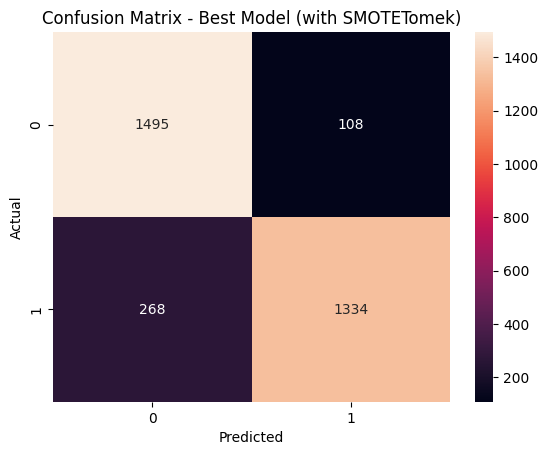

In [63]:
print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, Y_pred))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Model (with SMOTETomek)')
plt.show()

## Feature Importance

In [65]:
importance = final_xgb_clf.feature_importances_

feature_names = []
for name, transformer, columns in preprocessor.transformers_:
    if name == 'onehot':
        oh_features = transformer.get_feature_names_out(input_features=columns)
        feature_names.extend(oh_features)
    elif name == 'numerical_scaler':
        feature_names.extend(columns)

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance Ranking:")
print(feature_importance_df)


Feature Importance Ranking:
                 Feature  Importance
105    cmdb_ci_Server_40    0.009167
31    assigned_to_User_2    0.008992
117    cmdb_ci_Server_51    0.008229
61   assigned_to_User_47    0.007873
52   assigned_to_User_39    0.007716
..                   ...         ...
123    cmdb_ci_Server_57    0.003429
135    cmdb_ci_Server_68    0.003394
161    cmdb_ci_Server_91    0.003340
139    cmdb_ci_Server_71    0.003182
137     cmdb_ci_Server_7    0.003059

[199 rows x 2 columns]


## Heatmap Correlation (Features)

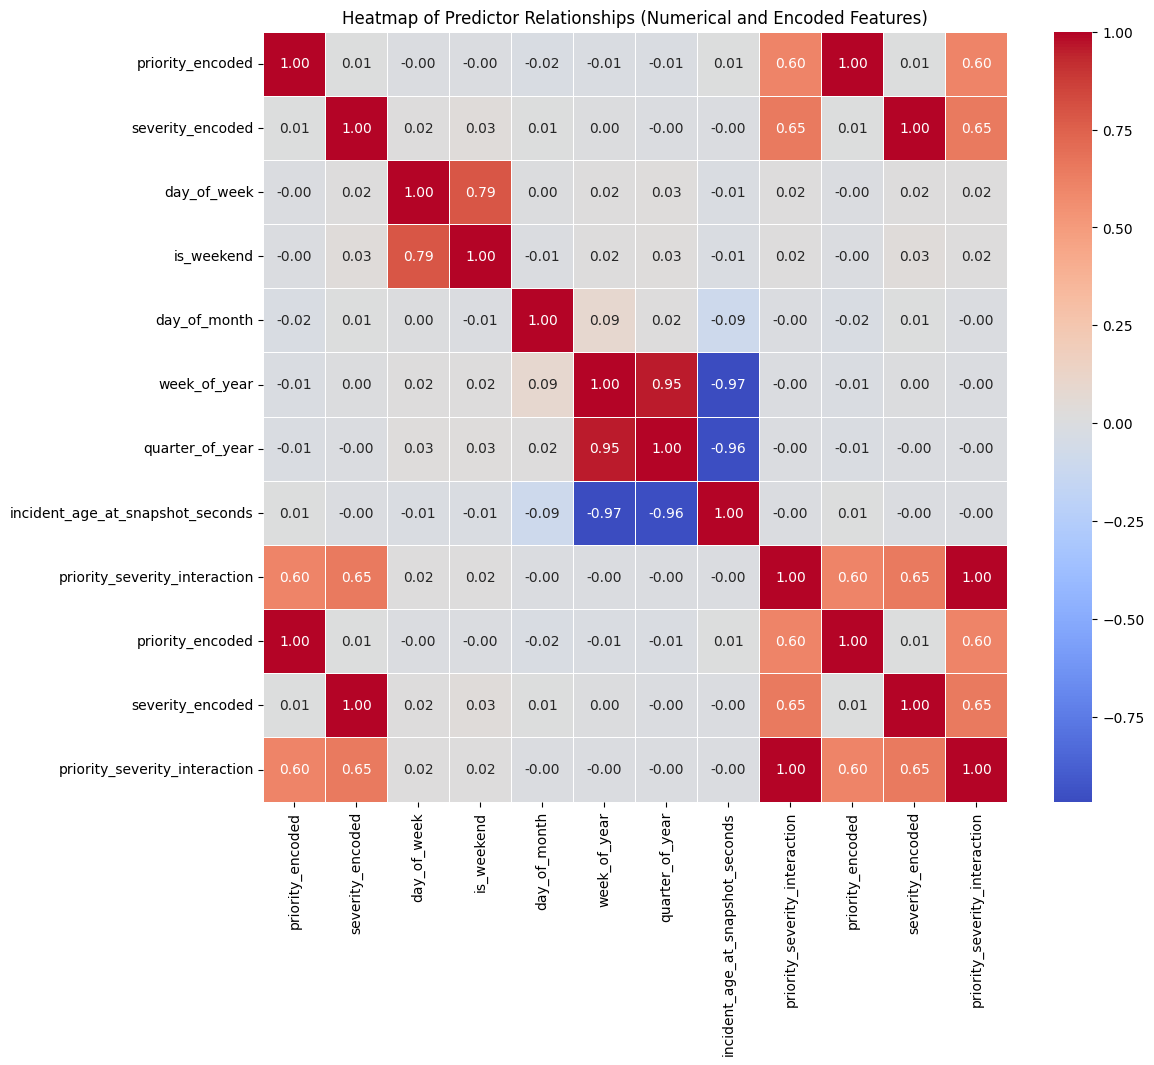

In [67]:
# heatmap correlation of numerical features

numerical_and_encoded_cols = numerical_features + ['priority_encoded', 'severity_encoded', 'priority_severity_interaction']
correlation_df = df_balanced[numerical_and_encoded_cols]

correlation_matrix = correlation_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Predictor Relationships (Numerical and Encoded Features)')
plt.show()